<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/DLL30_DZ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Свёрточные сети»
Перед вами домашнее задание по теме «Свёрточные сети».

Цель задания: научиться базово подбирать архитектуру, строить и обучать свёрточные нейронные сети для решения задачи классификации.

Контекст
Это домашнее задание по сути является продолжением предыдущего. В нём вы меняете архитектуру сети с полносвязной на свёрточную.

Задание
Постройте модель, используя архитектуру со свёрточными слоями, для классификации Fashion MNIST. Итоговое качество (accuracy) должно быть не ниже 89,5.

Инструкция к выполнению задания

1. Скачайте тренировочную и тестовою часть датасета Fashion MNIST
2. Постройте архитектуру модели, используя свёрточные слои, слои регуляризации и один финальный полносвязный слой
3. Обучите модель до необходимого качества. Если сеть не обучается до необходимого качества, попробуйте поменять архитектуру сети, варьируя параметры свёрток, количество каналов, количество свёрточных слоёв, слои регуляризации, тип оптимайзера и т. д.



# 0. Импорт библиотек и пользовательские функции

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import time

In [ ]:
import torch
import torchvision as tv
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
device ='cuda' if torch.cuda.is_available else 'cpu'
print(f'Using {device} device')

Using cuda device


# 1. Загрузка данных

In [ ]:
transform = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])
train_set = tv.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = tv.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 17110419.33it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272340.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4991259.50it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6898491.05it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_set[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
BATCH_SIZE=32


## 1.1. Визуализация

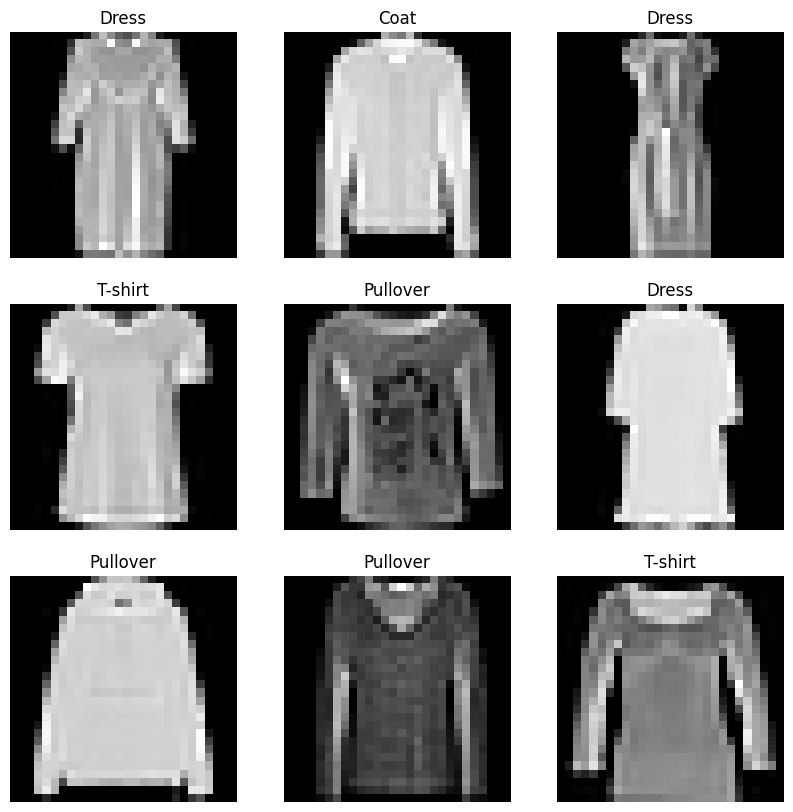

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_set), size = (1,)).item()
    image, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## 1.2. Загрузчики данных pytorch для train и test при использовании gPU

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True),
        torch.utils.data.DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
# def preprocess(x, y):
#     return x.view(-1, 1, 28, 28).to(device), y.to(device)

In [ ]:
# class WrappedDataLoader:
#     def __init__(self, dl, func):
#         self.dl = dl
#         self.func = func

#     def __len__(self):
#         return len(self.dl)

#     def __iter__(self):
#         for b in self.dl:
#             yield (self.func(*b))

In [ ]:
train_loader, test_loader = get_data(train_set, test_set, BATCH_SIZE)
# train_loader = WrappedDataLoader(train_loader, preprocess)
# test_loader = WrappedDataLoader(test_loader, preprocess)

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) <built-in method type of Tensor object at 0x7aefb663d8a0>


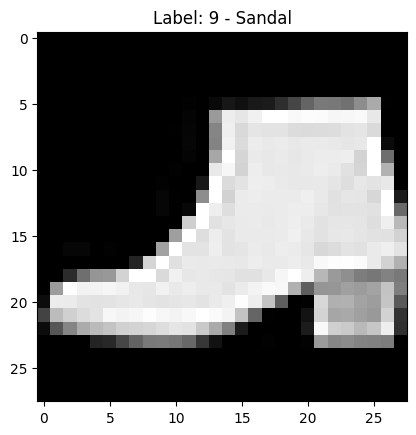

Labels batch shape: torch.Size([32])


In [ ]:
for X,y in train_loader:
    train_features, train_labels = next(iter(train_loader))
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.type}')
    image = train_features[0].squeeze()
    label = train_labels[0]
    sample_idx= torch.randint((label), size = (1,)).item()
    plt.title(f"Label: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"Labels batch shape: {train_labels.size()}")
    break

# 2. Выбор базовой архитектуры

Подсчет размерности. (-1) - означает, что размер батча определяется тем, что ввели ( м.б. и batch_size, и 1)
На вход: к-во каналов, ширина изображения, высота изображения или размер батча, к-во каналов, ширина изображения, высота изображения
Для conv2d: к-во каналов, к-во фильтров, (ширина - ширина ядра + ширина паддинга + 1) * (высота - высота ядра + высота паддинга + 1)
для пулинга: к-во каналов, к-во фильтров, (ширина/ширина ядра) * (высота/ высота ядра)


In [ ]:
class cnn_base(nn.Module):
    def __init__(self, num_classes):
        super(cnn_base, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1,24,kernel_size=3,padding=1), # (на входе -1, 1, 28, 28), на выходе -1, 24, (28-3+1+1), (28-3+1+1)
            nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3), # на входе (-1,24, 27,27), на выходе (-1,24,27/3, 27/3)
            nn.Conv2d(24,128,kernel_size=2,padding=1), # на входе -1,24,9,9, на выходе -1, 128, (9+1+1-2), (9+1+1-2)
            nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3) # на входе -1,128, 9,9 , на выходе -1, 128, (9/3), (9/3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*3*3,48),
            nn.ReLU(inplace=True),
            nn.Linear(48, num_classes)
        )
    def forward(self,x):
        x = self.feature(x) # на выходе -1,128,3,3
        x = x.view(x.size(0),-1) # на выходe -1,128,9
        x = self.classifier(x) # на входе -1, 128,9, на выходе сначала -1, 48, затем -1, 10
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #training using GPU
model= cnn_base(10).to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             240
              ReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3             [-1, 24, 9, 9]               0
            Conv2d-4          [-1, 128, 10, 10]          12,416
              ReLU-5          [-1, 128, 10, 10]               0
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                   [-1, 48]          55,344
              ReLU-8                   [-1, 48]               0
            Linear-9                   [-1, 10]             490
Total params: 68,490
Trainable params: 68,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 0.26
Estimated Total Size (MB): 0.77
---------------------------------------------

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.001)

In [ ]:
# Гиперпараметры  базовой модели

learning_rate = 0.001

epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        # Если использовать WrappedDataLoader и preprocess, то следующую строку не надо
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, loss_fn, optimizer, num_epochs):

    accuracy_max = 0.8
    epoch_opt = 1
    test_loss_opt = 0.
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            # Если использовать WrappedDataLoader и preprocess, то следующую строку не надо
            X, y = X.to(device),y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        # test_acc, test_loss = evaluate(test_iter, net, loss_fn)
        test_acc= evaluate_accuracy(test_iter, net, device)
        if test_acc > accuracy_max:
          accuracy_max = test_acc
          epoch_opt = epoch
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return accuracy_max, epoch_opt

# 3. Обучение и оценка базовой модели

In [ ]:
accuracy_max, epoch_opt = train(model, train_loader, test_loader, loss_fn, optimizer, epochs)

epoch 1, loss 0.0179, train acc 0.790, test acc 0.843, time 12.7 sec
epoch 2, loss 0.0120, train acc 0.862, test acc 0.864, time 11.9 sec
epoch 3, loss 0.0108, train acc 0.874, test acc 0.875, time 12.0 sec
epoch 4, loss 0.0100, train acc 0.883, test acc 0.884, time 12.0 sec
epoch 5, loss 0.0095, train acc 0.890, test acc 0.871, time 11.7 sec
epoch 6, loss 0.0091, train acc 0.894, test acc 0.889, time 11.5 sec
epoch 7, loss 0.0087, train acc 0.899, test acc 0.890, time 11.7 sec
epoch 8, loss 0.0085, train acc 0.902, test acc 0.881, time 11.9 sec
epoch 9, loss 0.0082, train acc 0.904, test acc 0.883, time 12.0 sec
epoch 10, loss 0.0081, train acc 0.906, test acc 0.898, time 12.0 sec


Очевидно, после 7 эпохи началось переобучение модели, и accuracy 90% на тесте не достигнута, хотя получен близкий к желаемому результат ( 0.89). По-видимому, кардинальные изменения в архитектуре модели не требуются.  На первом этапе попробую уменьшить шаг обучения после 7 эпохи и увеличу к-во эпох до 15. Далее планирую поэкспериментировать с kernel_size фильтров в сверточных слоях и слоях пулинга, а также с используемыми оптимизаторами

In [ ]:
df_results= pd.DataFrame(columns = ['architecture','optimizer', 'lr', 'accuracy',  'epoch'])
df_results.loc[len(df_results.index)] = ['cnn_base', 'Adam', learning_rate, accuracy_max, epoch_opt]
df_results

,architecture,optimizer,lr,accuracy,epoch
0,cnn_base,Adam,0.001,0.8984,9


# 4.  Оптимизация базовой модели

## 4.1. Изменение скорости обучения после начала переобучения модели и увеличение кол-ва эпох

In [ ]:
def train_(net, train_iter, test_iter, loss_fn, optimizer, num_epochs):

    accuracy_max = 0.8
    epoch_opt = 1
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            X, y = X.to(device),y.to(device)
            if epoch > 6:
              optimizer = torch.optim.Adam(model.parameters(),lr=0.0005, weight_decay=0.001)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc= evaluate_accuracy(test_iter, net, device)

        if test_acc > accuracy_max:
          accuracy_max = test_acc
          epoch_opt = epoch

        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f' test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return accuracy_max, epoch_opt

In [ ]:
accuracy_max, epoch_opt = train_(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=15)

epoch 1, loss 0.0080, train acc 0.908 test acc 0.897, time 11.9 sec
epoch 2, loss 0.0078, train acc 0.909 test acc 0.898, time 12.1 sec
epoch 3, loss 0.0077, train acc 0.911 test acc 0.902, time 12.0 sec
epoch 4, loss 0.0076, train acc 0.911 test acc 0.901, time 12.0 sec
epoch 5, loss 0.0075, train acc 0.913 test acc 0.896, time 12.1 sec
epoch 6, loss 0.0075, train acc 0.913 test acc 0.905, time 13.0 sec
epoch 7, loss 0.0074, train acc 0.915 test acc 0.904, time 18.4 sec
epoch 8, loss 0.0072, train acc 0.917 test acc 0.895, time 18.3 sec
epoch 9, loss 0.0076, train acc 0.914 test acc 0.896, time 18.9 sec
epoch 10, loss 0.0078, train acc 0.913 test acc 0.898, time 14.5 sec
epoch 11, loss 0.0081, train acc 0.910 test acc 0.897, time 14.6 sec
epoch 12, loss 0.0082, train acc 0.909 test acc 0.901, time 12.5 sec
epoch 13, loss 0.0083, train acc 0.908 test acc 0.891, time 13.1 sec
epoch 14, loss 0.0084, train acc 0.907 test acc 0.897, time 12.4 sec
epoch 15, loss 0.0085, train acc 0.906 test

In [ ]:
df_results.loc[len(df_results.index)] = ['cnn_base_15', 'Adam', 0.0005, accuracy_max, epoch_opt]

In [ ]:
df_results

,architecture,optimizer,lr,accuracy,epoch
0,cnn_base,Adam,0.0010,0.8984,9
1,cnn_base_15,Adam,0.0005,0.9049,5


Результат достигнут! Но интересно проверить и другие варианты

In [ ]:
del model

In [ ]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class cnn(nn.Module):
    def __init__(self,num_classes):
        super(cnn, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1,24,kernel_size=3,padding=1), # (на входе -1, 1, 28, 28), на выходе -1, 24, (28-3+1+1), (28-3+1+1)
            nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2), # на входе (-1,24, 27,27), на выходе (-1,24,27/2, 27/2), при делении округляем в большую сторону
            nn.Conv2d(24,128,kernel_size=3,padding=1), # на входе -1,24,14,14, на выходе -1, 128, (14+1+1-3), (14+1+1-3)
            nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2) # на входе -1,128, 13,13 , на выходе -1, 128, (13/2), (13/2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*7*7,48),
            nn.ReLU(inplace=True),
            nn.Linear(48,num_classes)
        )
    def forward(self,x):
        x = self.feature(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [ ]:
device = 'cuda'

In [ ]:
model = cnn(10).to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             240
              ReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          27,776
              ReLU-5          [-1, 128, 14, 14]               0
         MaxPool2d-6            [-1, 128, 7, 7]               0
            Linear-7                   [-1, 48]         301,104
              ReLU-8                   [-1, 48]               0
            Linear-9                   [-1, 10]             490
Total params: 329,610
Trainable params: 329,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 1.26
Estimated Total Size (MB): 2.01
-------------------------------------------

## 4.3. Изменение оптимизаторов

In [ ]:
optimizers = []
optimizers.append(("RMSProp", torch.optim.RMSprop(model.parameters(), lr=learning_rate)))
optimizers.append(("AdamW", torch.optim.AdamW(model.parameters(), lr=learning_rate)))
optimizers.append(("Adagrad", torch.optim.Adagrad(model.parameters(), lr=learning_rate)))
optimizers.append(("NADam", torch.optim.NAdam(model.parameters(), lr=learning_rate)))

In [ ]:
df_results_= pd.DataFrame(columns = ['architecture','optimizer', 'lr', 'accuracy',  'epoch'])
for name, optimizer in optimizers:
    print(name)
    accuracy = 0
    epoch_opt = 1
    accuracy,  epoch_opt = train(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10)
    df_results_.loc[len(df_results_.index)] = ['cnn', name, learning_rate, accuracy, epoch_opt]


RMSProp
epoch 1, loss 0.0014, train acc 0.984, test acc 0.913, time 13.0 sec
epoch 2, loss 0.0013, train acc 0.985, test acc 0.910, time 12.9 sec
epoch 3, loss 0.0012, train acc 0.986, test acc 0.914, time 12.8 sec
epoch 4, loss 0.0012, train acc 0.986, test acc 0.908, time 12.7 sec
epoch 5, loss 0.0011, train acc 0.987, test acc 0.907, time 12.8 sec
epoch 6, loss 0.0011, train acc 0.988, test acc 0.906, time 12.7 sec
epoch 7, loss 0.0010, train acc 0.988, test acc 0.907, time 12.9 sec
epoch 8, loss 0.0010, train acc 0.988, test acc 0.911, time 12.8 sec
epoch 9, loss 0.0009, train acc 0.989, test acc 0.906, time 12.9 sec
epoch 10, loss 0.0010, train acc 0.989, test acc 0.911, time 12.8 sec
AdamW
epoch 1, loss 0.0010, train acc 0.989, test acc 0.912, time 13.0 sec
epoch 2, loss 0.0009, train acc 0.989, test acc 0.907, time 13.0 sec
epoch 3, loss 0.0009, train acc 0.990, test acc 0.912, time 13.1 sec
epoch 4, loss 0.0009, train acc 0.989, test acc 0.908, time 13.0 sec
epoch 5, loss 0.000

In [ ]:
df_results_.sort_values(by='accuracy', ascending=False)

,architecture,optimizer,lr,accuracy,epoch
2,cnn,Adagrad,0.001,0.9160,8
0,cnn,RMSProp,0.001,0.9144,2
3,cnn,NADam,0.001,0.9131,1
1,cnn,AdamW,0.001,0.9127,4


In [30]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
accuracy,  epoch_opt = train(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10)

epoch 1, loss 0.0001, train acc 0.999, test acc 0.913, time 12.9 sec
epoch 2, loss 0.0001, train acc 1.000, test acc 0.912, time 12.9 sec
epoch 3, loss 0.0001, train acc 1.000, test acc 0.913, time 14.9 sec
epoch 4, loss 0.0001, train acc 1.000, test acc 0.913, time 12.8 sec
epoch 5, loss 0.0001, train acc 1.000, test acc 0.914, time 12.8 sec
epoch 6, loss 0.0000, train acc 1.000, test acc 0.914, time 12.9 sec
epoch 7, loss 0.0000, train acc 1.000, test acc 0.914, time 12.6 sec
epoch 8, loss 0.0000, train acc 1.000, test acc 0.915, time 12.8 sec
epoch 9, loss 0.0000, train acc 1.000, test acc 0.914, time 12.8 sec
epoch 10, loss 0.0000, train acc 1.000, test acc 0.914, time 12.7 sec


In [32]:
y_pred = []
y_true = []
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    y_pred_iter = model(X)
    y_pred.extend(y_pred_iter.detach())
    y_true.extend(y.detach())

y_pred = torch.Tensor([torch.argmax(x) for x in y_pred])
y_true = torch.Tensor(y_true)

In [33]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.9141


Вывод:

Преодолеть порог изначально удалось с помощью уменьшенного шага обучения при выбранной архитектуре. Далее, изменяя размеры фильтров в слоях свертки и пулинга и варьируя оптимизаторы, удалось  поднять accuracy на тесте до 0.916 ghb bcgjkmpjdfybb Фвфпкфв